In [250]:


import numpy as np # linear algebra
import pandas as pd # data processing
import random

In [251]:
import gymnasium as gym
env = gym.make("Taxi-v3", render_mode="rgb_array")  # Enable image rendering


In [252]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

There are  500  possible states


In [253]:
action_space = env.action_space.n
print("There are ", action_space, " possible actions")

There are  6  possible actions


In [254]:
#Lets create our Qtable of size (state_space, action_space) and initialized each values at 0 using np.zeros
def initialize_q_table(state_space, action_space):
    Qtable = np.zeros((state_space,action_space))
    return Qtable

In [255]:
# Create our table with state_size rows and action_size columns (500x6)
Qtable_taxi = initialize_q_table(state_space, action_space)
print(Qtable_taxi)
print("Q-table shape: ", Qtable_taxi.shape)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Q-table shape:  (500, 6)


In [256]:
# Training parameters
n_training_episodes = 50000 # Total training episodes
learning_rate = 0.1        # Learning rate

# Evaluation parameters
n_eval_episodes = 100       # Total number of test episodes

# DO NOT MODIFY EVAL_SEED
eval_seed=[]





# Environment parameters
env_id = "Taxi-v3"    # Name of the environment
max_steps = 99              # Max steps per episode
gamma = 0.95                # Discounting rate # This is the discounting rate, which determines the importance of future rewards. A value close to 1 means future rewards are high


# Exploration parameters
epsilon = 1.0               # Exploration rate
max_epsilon = 1.0           # Exploration probability at start
min_epsilon = 0.05          # Minimum exploration probability
decay_rate = 0.0008       # Exponential decay rate for exploration prob

In [257]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    for episode in range(n_training_episodes):
        # Decay epsilon over episodes
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

        # Reset the environment
        state = env.reset()
        if isinstance(state, tuple):  # Handle tuple returned by reset()
            state = state[0]
        done = False

        # Loop for each step in the episode
        for step in range(max_steps):
            # Choose an action using epsilon-greedy policy
            action = epsilon_greedy_policy(Qtable, state, epsilon)

            # Take the chosen action and observe the outcome
            new_state, reward, done, truncated, info = env.step(action)

            # Update Q-value using the Q-learning formula
            Qtable[state, action] = Qtable[state, action] + learning_rate * (
                reward + gamma * np.max(Qtable[new_state]) - Qtable[state, action]
            )

            # If done or truncated, stop the episode
            if done or truncated:
                break

            # Update the state
            state = new_state

    return Qtable


In [258]:
def epsilon_greedy_policy(Qtable, state, epsilon):
    random_num = random.uniform(0,1) # Randomly generate a number between 0 and 1

    if random_num > epsilon: # if random_num > greater than epsilon --> exploitation
        #Take the action with the highest value given a state
        #Exploitation means the agent will choose the action that has the highest Q-value

        action = np.argmax(Qtable[state])

    else:      # else -----> 
        action = env.action_space.sample() # Take a random action

    return action

In [259]:
Qtable_taxi = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_taxi)

In [260]:
Qtable_taxi

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  2.68594045,   3.88410752,   2.58596303,   3.83656259,
          5.20997639,  -5.24056578],
       [  7.76463877,   9.21366974,   7.74882597,   9.29160488,
         10.9512375 ,   0.35063166],
       ...,
       [ -1.47751759,  12.57872428,  -0.16456586,   1.33182988,
         -7.40844723,  -7.18062553],
       [ -2.52860976,  -2.65908254,  -2.71309951,   6.46652118,
         -9.91066409, -10.36370579],
       [  0.73018769,   4.06710402,   2.44798332,  17.99996854,
         -1.73246728,  -1.12686066]])

In [261]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed=None):
    """
    Evaluate the agent for 'n_eval_episodes' episodes and return average reward and std of reward.
    
    :param env: The evaluation environment
    :param max_steps: Maximum number of steps per episode
    :param n_eval_episodes: Number of episodes to evaluate the agent
    :param Q: The Q-table
    :param seed: The evaluation seed array (for reproducibility, optional)
    :return: mean_reward, std_reward
    """
    episode_rewards = []
    
    for episode in range(n_eval_episodes):
        if seed:
            state = env.reset(seed=seed[episode])
        else:
            state = env.reset()
        if isinstance(state, tuple):  # Handle tuple returned by reset()
            state = state[0]
        
        total_rewards_ep = 0
        for step in range(max_steps):
            # Take the action with the highest Q-value for the current state
            action = np.argmax(Q[state][:])
            new_state, reward, done, truncated, info = env.step(action)
            
            total_rewards_ep += reward
            
            if done or truncated:
                break
            
            state = new_state
        
        episode_rewards.append(total_rewards_ep)
    
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    
    return mean_reward, std_reward


In [262]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_taxi, eval_seed)
print(f"Mean_reward = {mean_reward:.2f} +/- {std_reward:.2f}")

Mean_reward = 8.14 +/- 2.40


In [263]:
def train_with_rewards(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    training_rewards = []  # List to track rewards per episode
    for episode in range(n_training_episodes):
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        state = env.reset()
        if isinstance(state, tuple):  # Handle tuple returned by reset()
            state = state[0]
        done = False
        total_rewards_ep = 0  # Track total rewards for the episode
        for step in range(max_steps):
            action = epsilon_greedy_policy(Qtable, state, epsilon)
            new_state, reward, done, truncated, info = env.step(action)
            Qtable[state, action] = Qtable[state, action] + learning_rate * (
                reward + gamma * np.max(Qtable[new_state]) - Qtable[state, action]
            )
            total_rewards_ep += reward  # Accumulate rewards
            if done or truncated:
                break
            state = new_state
        training_rewards.append(total_rewards_ep)  # Add episode rewards
    return Qtable, training_rewards


In [264]:
# Evaluate the agent periodically during training
eval_mean_rewards = []
eval_std_rewards = []
eval_interval = 1000  # Evaluate every 1000 episodes

for i in range(0, n_training_episodes, eval_interval):
    mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_taxi, eval_seed)
    eval_mean_rewards.append(mean_reward)
    eval_std_rewards.append(std_reward)


In [265]:
import matplotlib.pyplot as plt

def plot_efficiency(training_rewards, eval_mean_rewards, eval_std_rewards):
    """
    Plots the rewards collected during training and evaluation performance separately.
    """

    # Training reward plot
    plt.figure(figsize=(10, 5))  # Create a new figure for training rewards
    plt.plot(range(1, len(training_rewards) + 1), training_rewards, color='blue', alpha=0.7, label="Training Reward")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Performance")
    plt.legend()
    plt.show()  # Showing training plot separately

    # Evaluation performance plot
    plt.figure(figsize=(10, 5))  # Create a new figure for evaluation performance
    plt.errorbar(range(1, len(eval_mean_rewards) + 1), eval_mean_rewards, yerr=eval_std_rewards, fmt='-o', color='orange', label="Mean Reward ± STD")
    plt.xlabel("Evaluation Interval")
    plt.ylabel("Mean Reward")
    plt.title("Evaluation Performance")
    plt.legend()
    plt.show()  # Showing evaluation plot separately


In [266]:
Qtable_taxi, training_rewards = train_with_rewards(
    n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_taxi
)

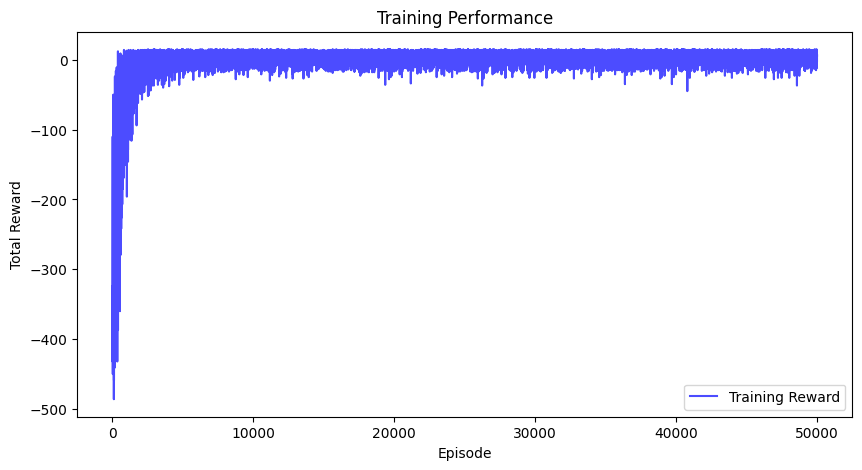

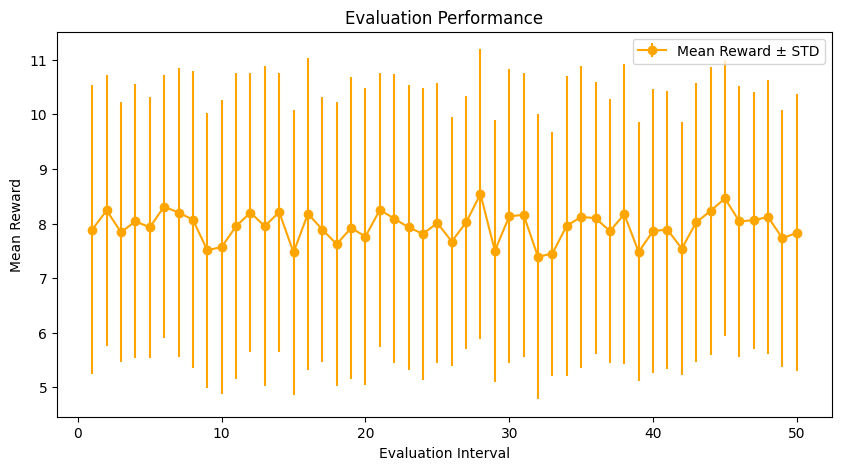

In [267]:
plot_efficiency(training_rewards, eval_mean_rewards, eval_std_rewards)


In [268]:

import time
from IPython.display import clear_output

def visualize_agent_matplotlib(env, Qtable, max_steps=20, delay=0.5):
    """
    Animates the Taxi-v3 agent as it moves step by step toward the goal.
    
    :param env: The Taxi-v3 environment
    :param Qtable: The trained Q-table
    :param max_steps: Maximum steps per episode
    :param delay: Delay (in seconds) between each step
    """
    state = env.reset()[0]  # Reset the environment
    done = False

    plt.figure(figsize=(4, 4))

    for step in range(max_steps):
        clear_output(wait=True)  # Clear previous frame
        plt.clf()  # Clear the previous image

        #  Render the environment (Agent Movement)
        img = env.render()  
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Step {step + 1}")
        plt.show()

        time.sleep(delay)  # Pause for smooth animation

        # Choose the best action based on the Q-table
        action = np.argmax(Qtable[state])
        state, reward, done, truncated, info = env.step(action)

        if done or truncated:
            break  # Stop if the agent reaches the goal

    print("The taxi has successfully pick the passinger and droped him to his destinition :-) ")



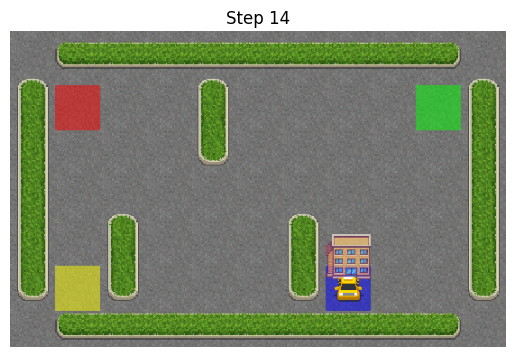

The taxi has successfully pick the passinger and droped him to his destinition :-) 


In [269]:
visualize_agent_matplotlib(env, Qtable_taxi)
